In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from utils.visualize_predictions import visualize_predictions
from utils.plot_training_validation import plot_training_validation
from utils.evaluation import evaluate_model
from utils.train import train_model
from utils.load_model_weights import load_model_weights

In [2]:
num_of_classes = 3
merged_dataset_dir = "../{}_classes_merged_dataset".format(num_of_classes)
save_model_path = "../saved_models/{}/simplecnn".format(num_of_classes)

batch_size = 16
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

test_val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Load the entire dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=merged_dataset_dir, transform=train_transform)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the sizes of each split
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensures all samples are used

# Ensure reproducibility by setting a manual seed
torch.manual_seed(42)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Ensures reproducible splits
)

# Apply different transforms to validation and test datasets
# Since random_split returns Subset objects, we need to set the transform manually
# To do this, we override the transform attribute for val and test
# Access the underlying dataset with train_dataset.dataset
val_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    val_dataset.indices
)

test_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    test_dataset.indices
)

# Create DataLoaders for each split
num_workers = 8  # Adjust based on your system's capabilities

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for training
    num_workers=num_workers,
    pin_memory=True  # Speeds up data transfer to GPU if using CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle for validation
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle for testing
    num_workers=num_workers,
    pin_memory=True
)

# Optional: Print dataset sizes for verification
print(f"\nTotal samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")



Total samples: 4479
Training samples: 3583
Validation samples: 447
Test samples: 449


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 9 * 9, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolution + BN + ReLU + Pool layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # raw logits (no softmax)
        return x

In [5]:
model = SimpleCNN(num_classes=len(full_dataset.classes)).to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


In [7]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    gradient_clip=1.0,
    print_interval=10,
    save_dir=save_model_path,
    save_best=True,
    save_every_epoch=False,
)


Epoch 1/10 - Rozpoczynam trening:


Epoch 1: Train Loss: 1.2447 | Train Acc: 51.07%
Epoch 1 - Rozpoczynam walidację:


Walidacja:  61%|██████    | 17/28 [00:29<00:10,  1.08it/s]

Walidacja: Batch 10/28, Loss: 1.1622
Walidacja: Batch 20/28, Loss: 1.2961


Walidacja:  93%|█████████▎| 26/28 [00:29<00:01,  1.89it/s]

Walidacja: Batch 28/28, Loss: 1.0627


c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Val Loss: 1.0593 | Val Acc: 50.34%
Najlepszy model zapisany: ../saved_models/3/simplecnn\best_model.pth

Epoch 2/10 - Rozpoczynam trening:


Epoch 2: Train Loss: 0.8034 | Train Acc: 59.92%
Epoch 2 - Rozpoczynam walidację:


Walidacja:  61%|██████    | 17/28 [00:27<00:10,  1.05it/s]

Walidacja: Batch 10/28, Loss: 0.8326
Walidacja: Batch 20/28, Loss: 0.6196


Walidacja:  89%|████████▉ | 25/28 [00:27<00:01,  1.86it/s]

Walidacja: Batch 28/28, Loss: 0.6954


Epoch 2: Val Loss: 0.7219 | Val Acc: 61.30%
Najlepszy model zapisany: ../saved_models/3/simplecnn\best_model.pth

Epoch 3/10 - Rozpoczynam trening:


Epoch 3: Train Loss: 0.7618 | Train Acc: 62.38%
Epoch 3 - Rozpoczynam walidację:


Walidacja:  64%|██████▍   | 18/28 [00:26<00:10,  1.06s/it]

Walidacja: Batch 10/28, Loss: 0.6209
Walidacja: Batch 20/28, Loss: 0.5407


Walidacja:  64%|██████▍   | 18/28 [00:26<00:10,  1.06s/it]

Walidacja: Batch 28/28, Loss: 0.6959


Epoch 3: Val Loss: 0.6464 | Val Acc: 68.68%
Najlepszy model zapisany: ../saved_models/3/simplecnn\best_model.pth

Epoch 4/10 - Rozpoczynam trening:


Epoch 4: Train Loss: 0.7340 | Train Acc: 63.77%
Epoch 4 - Rozpoczynam walidację:


Walidacja:  61%|██████    | 17/28 [00:27<00:10,  1.04it/s]

Walidacja: Batch 10/28, Loss: 0.7017
Walidacja: Batch 20/28, Loss: 0.5344


Walidacja:  89%|████████▉ | 25/28 [00:27<00:01,  1.85it/s]

Walidacja: Batch 28/28, Loss: 0.6051


Epoch 4: Val Loss: 0.6225 | Val Acc: 71.81%
Najlepszy model zapisany: ../saved_models/3/simplecnn\best_model.pth

Epoch 5/10 - Rozpoczynam trening:


Epoch 5: Train Loss: 0.6923 | Train Acc: 66.48%
Epoch 5 - Rozpoczynam walidację:


Walidacja:  61%|██████    | 17/28 [00:28<00:11,  1.00s/it]

Walidacja: Batch 10/28, Loss: 0.5824
Walidacja: Batch 20/28, Loss: 0.4429


Walidacja:  89%|████████▉ | 25/28 [00:28<00:01,  1.77it/s]

Walidacja: Batch 28/28, Loss: 0.7210


Epoch 5: Val Loss: 0.6264 | Val Acc: 69.57%

Epoch 6/10 - Rozpoczynam trening:


Epoch 6: Train Loss: 0.6604 | Train Acc: 69.27%
Epoch 6 - Rozpoczynam walidację:


Walidacja:  61%|██████    | 17/28 [00:28<00:10,  1.02it/s]

Walidacja: Batch 10/28, Loss: 0.8040
Walidacja: Batch 20/28, Loss: 0.4110


Walidacja:  89%|████████▉ | 25/28 [00:28<00:01,  1.81it/s]

Walidacja: Batch 28/28, Loss: 0.5097


Epoch 6: Val Loss: 0.6288 | Val Acc: 70.25%

Epoch 7/10 - Rozpoczynam trening:


Epoch 7: Train Loss: 0.6478 | Train Acc: 69.69%
Epoch 7 - Rozpoczynam walidację:


Walidacja:  64%|██████▍   | 18/28 [00:27<00:10,  1.10s/it]

Walidacja: Batch 10/28, Loss: 0.7298
Walidacja: Batch 20/28, Loss: 0.3990


Walidacja:  64%|██████▍   | 18/28 [00:27<00:10,  1.10s/it]

Walidacja: Batch 28/28, Loss: 0.7408


Epoch 7: Val Loss: 0.6157 | Val Acc: 71.36%

Epoch 8/10 - Rozpoczynam trening:


Epoch 8: Train Loss: 0.6318 | Train Acc: 70.42%
Epoch 8 - Rozpoczynam walidację:


Walidacja:  46%|████▋     | 13/28 [00:29<00:13,  1.09it/s]

Walidacja: Batch 10/28, Loss: 0.7136


Walidacja:  75%|███████▌  | 21/28 [00:29<00:02,  2.93it/s]

Walidacja: Batch 20/28, Loss: 0.3789


Walidacja: 100%|██████████| 28/28 [00:29<00:00,  5.43it/s]

Walidacja: Batch 28/28, Loss: 0.5363


Epoch 8: Val Loss: 0.6085 | Val Acc: 67.79%

Epoch 9/10 - Rozpoczynam trening:


Epoch 9: Train Loss: 0.6296 | Train Acc: 70.89%
Epoch 9 - Rozpoczynam walidację:


Walidacja:  61%|██████    | 17/28 [00:27<00:12,  1.16s/it]

Walidacja: Batch 10/28, Loss: 0.7664
Walidacja: Batch 20/28, Loss: 0.5963


Walidacja:  61%|██████    | 17/28 [00:27<00:12,  1.16s/it]

Walidacja: Batch 28/28, Loss: 0.7150


Epoch 9: Val Loss: 0.6788 | Val Acc: 70.47%

Epoch 10/10 - Rozpoczynam trening:


Epoch 10: Train Loss: 0.6129 | Train Acc: 72.12%
Epoch 10 - Rozpoczynam walidację:


Walidacja:  61%|██████    | 17/28 [00:28<00:06,  1.59it/s]

Walidacja: Batch 10/28, Loss: 0.7569


Walidacja:  75%|███████▌  | 21/28 [00:29<00:03,  2.32it/s]

Walidacja: Batch 20/28, Loss: 0.5059


Walidacja:  89%|████████▉ | 25/28 [00:29<00:00,  3.29it/s]

Walidacja: Batch 28/28, Loss: 0.5935


Epoch 10: Val Loss: 0.6707 | Val Acc: 71.36%

Trening zakończony.


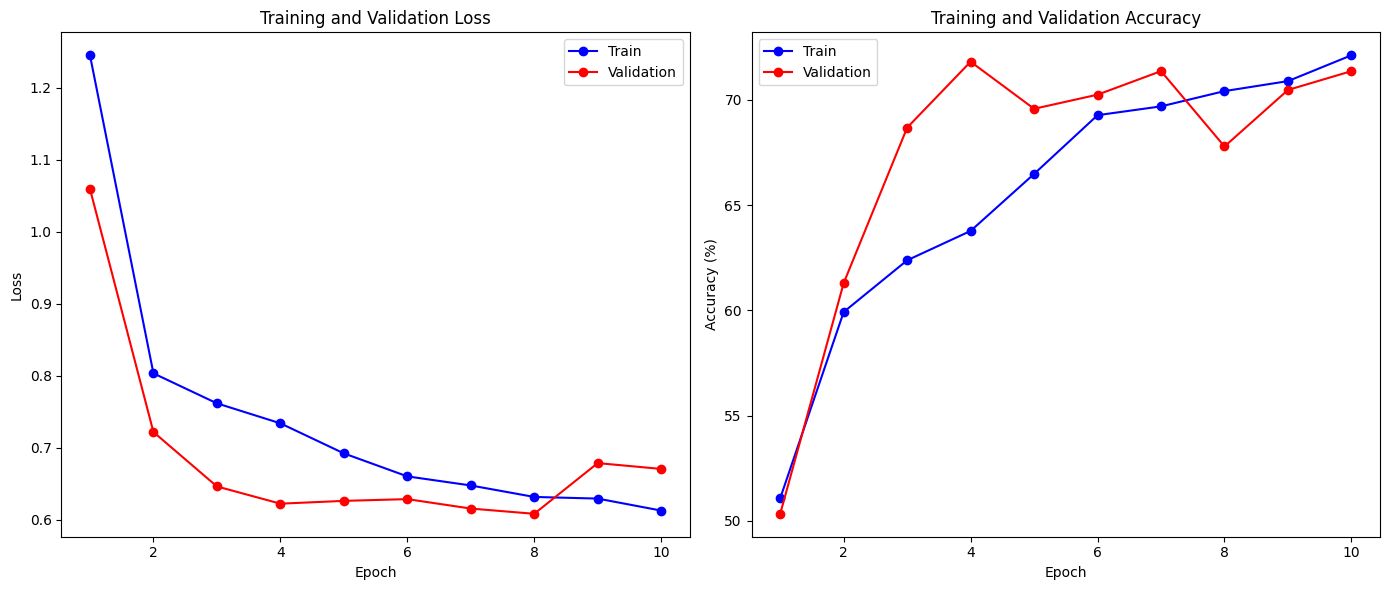

In [8]:
plot_training_validation(
    history["train_loss"], history["val_loss"], history["train_acc"], history["val_acc"]
)

In [9]:
# Optional
model = load_model_weights(model, save_model_path, device)

c:\Users\kubia\OneDrive\Pulpit\studia\uczenie głębokie\src\utils\load_model_weights.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path

Model weights loaded successfully from ../saved_models/3/simplecnn\best_model.pth



Test Loss: 0.5708 | Test Accuracy: 0.7572



Raport klasyfikacji:
               precision    recall  f1-score   support

   BACTERIAL       0.68      0.82      0.75       150
      NORMAL       0.89      0.89      0.89       151
       VIRAL       0.69      0.55      0.62       148

    accuracy                           0.76       449
   macro avg       0.76      0.76      0.75       449
weighted avg       0.76      0.76      0.75       449


Macierz konfuzji:
[[123   6  21]
 [  1 135  15]
 [ 56  10  82]]


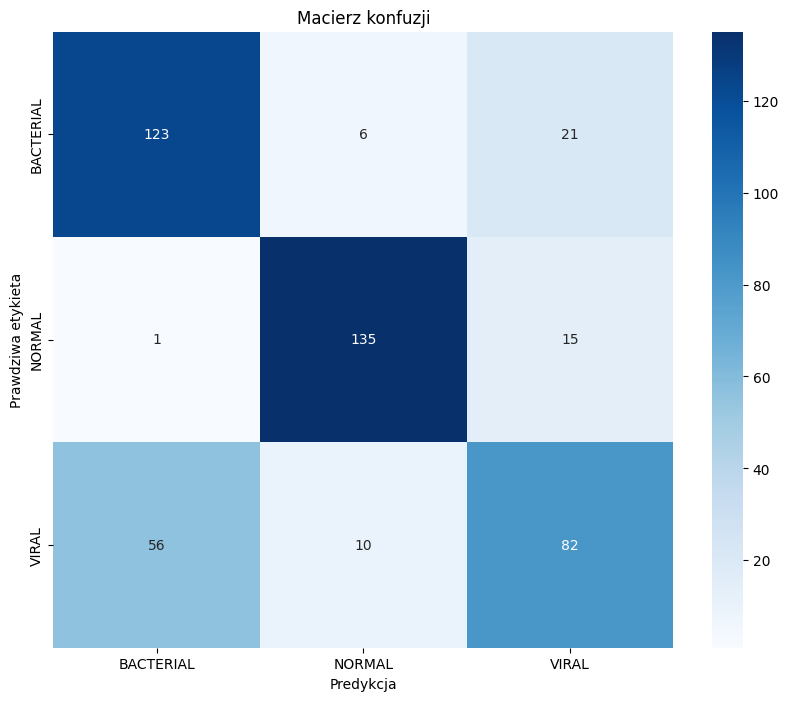

In [10]:
class_names = test_dataset.dataset.classes
evaluate_model(model, test_loader, criterion, device, class_names)

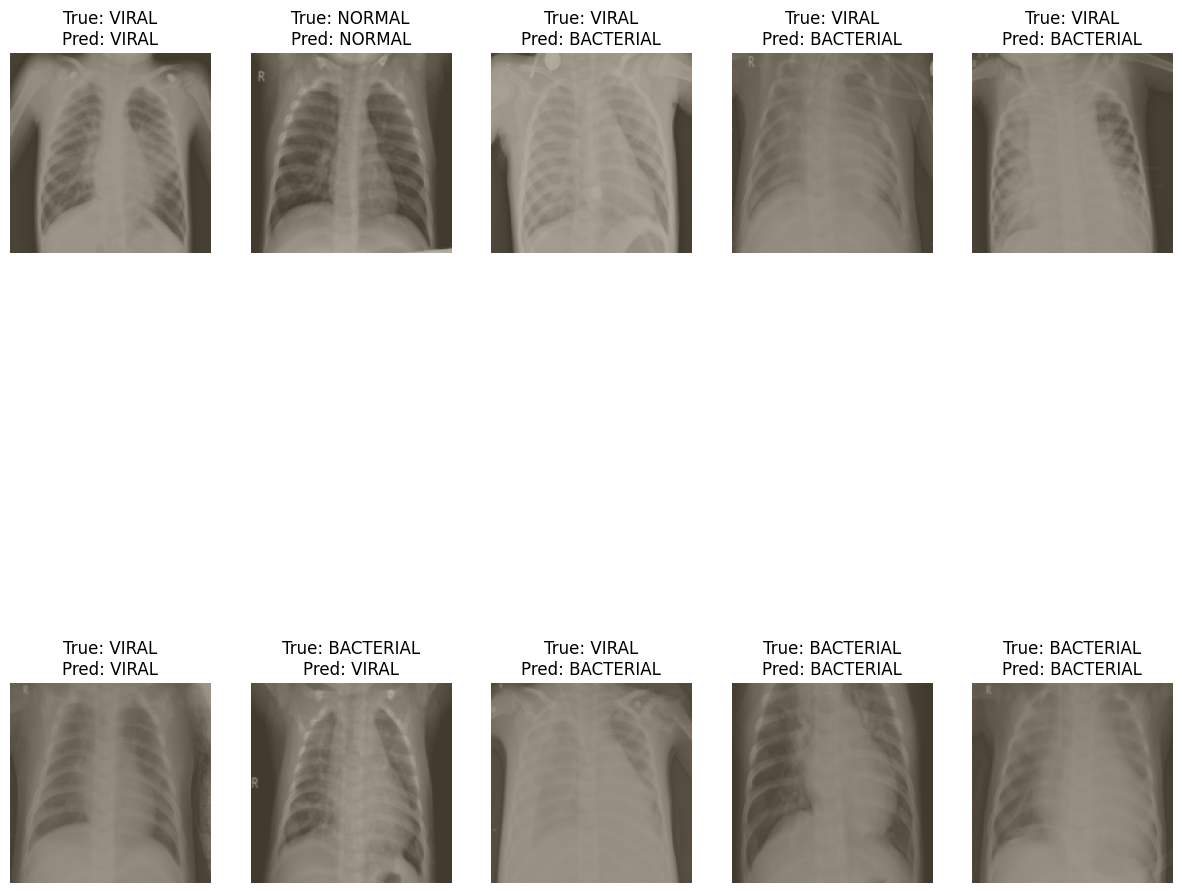

In [11]:
visualize_predictions(model, test_loader, test_dataset.dataset.classes, device, num_images=10)